# Restricted Boltzmann Machine Defintion

In [52]:
# Import PyTorch library
import torch
import torch.nn as nn

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [57]:
# https://github.com/khanhnamle1994/MetaRec/blob/b5e36cb579a88b32cdfb728f35f645d76b24ad95/Boltzmann-Machines-Experiments/RBM-CF-PyTorch/rbm.py#L23
# Create the Restricted Boltzmann Machine architecture
class RBM(nn.Module):
    def __init__(self, n_vis, n_hid):
        """
        Initialize the parameters (weights and biases) we optimize during the training process
        :param n_vis: number of visible units
        :param n_hid: number of hidden units
        """

        # Weights used for the probability of the visible units given the hidden units
        super().__init__()
        self.W = torch.randn(n_hid, n_vis, device=device)  # torch.rand: random normal distribution mean = 0, variance = 1

        # Bias probability of the visible units is activated, given the value of the hidden units (p_v_given_h)
        self.v_bias = torch.randn(1, n_vis, device=device)  # fake dimension for the batch = 1

        # Bias probability of the hidden units is activated, given the value of the visible units (p_h_given_v)
        self.h_bias = torch.randn(1, n_hid, device=device)  # fake dimension for the batch = 1

    def sample_h(self, x):
        """
        Sample the hidden units
        :param x: the dataset
        """

        # Probability h is activated given that the value v is sigmoid(Wx + a)
        # torch.mm make the product of 2 tensors
        # W.t() take the transpose because W is used for the p_v_given_h
        wx = torch.mm(x, self.W.t())
        # print(wx.shape)

        # Expand the mini-batch
        activation = wx + self.h_bias.expand_as(wx)
        # print(activation.shape)

        # Calculate the probability p_h_given_v
        p_h_given_v = torch.sigmoid(activation)

        # print("h sparse", p_h_given_v.is_sparse, torch.bernoulli(p_h_given_v).is_sparse)

        # Construct a Bernoulli RBM to predict whether an user loves the movie or not (0 or 1)
        # This corresponds to whether the n_hid is activated or not activated
        return p_h_given_v, torch.bernoulli(p_h_given_v)

    def sample_v(self, y):
        """
        Sample the visible units
        :param y: the dataset
        """

        # Probability v is activated given that the value h is sigmoid(Wx + a)
        wy = torch.mm(y, self.W)

        # Expand the mini-batch
        activation = wy + self.v_bias.expand_as(wy)

        # Calculate the probability p_v_given_h
        p_v_given_h = torch.sigmoid(activation)

        # print("v sparse", p_v_given_h.is_sparse, torch.bernoulli(p_v_given_h).is_sparse)

        # Construct a Bernoulli RBM to predict whether an user loves the movie or not (0 or 1)
        # This corresponds to whether the n_vis is activated or not activated
        return p_v_given_h, torch.bernoulli(p_v_given_h)

    def train_model(self, v0, vk, ph0, phk):
        """
        Perform contrastive divergence algorithm to optimize the weights that minimize the energy
        This maximizes the log-likelihood of the model
        """

        # Approximate the gradients with the CD algorithm
        self.W += (torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t()

        # Add (difference, 0) for the tensor of 2 dimensions
        self.v_bias += torch.sum((v0 - vk), 0)
        self.h_bias += torch.sum((ph0 - phk), 0)

In [ ]:
cuda = torch.device('cuda')

# General Imports

In [ ]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import gzip
import json
from tqdm import tqdm
import os
from collections import Counter
from datetime import datetime
import math
tqdm.pandas() #for progres_apply etc.

In [ ]:
#read file line-by-line and parse json, returns dataframe
def parse_json(filename_gzipped_python_json, read_max=-1):
  #read gzipped content
  f=gzip.open(filename_gzipped_python_json,'r')
  
  #parse json
  parse_data = []
  for line in tqdm(f): #tqdm is for showing progress bar, always good when processing large amounts of data
    line = line.decode('utf-8')
    line = line.replace('true','True') #difference json/python
    line = line.replace('false','False')
    parsed_result = eval(line) #load python nested datastructure
    # print(filename_gzipped_python_json == steam_path + steam_reviews and 'user_id' not in parsed_result)
    # break
    if filename_gzipped_python_json == steam_path + steam_reviews and 'user_id' not in parsed_result:
      continue
      
    parse_data.append(parsed_result)
    if read_max !=-1 and len(parse_data) > read_max:
      print(f'Break reading after {read_max} records')
      break
  print(f"Reading {len(parse_data)} rows.")

  #create dataframe
  df= pd.DataFrame.from_dict(parse_data)
  return df

In [ ]:
steam_path = './data/'
metadata_games = 'steam_games.json.gz' 
user_items = 'australian_users_items.json.gz'
user_reviews = 'australian_user_reviews.json.gz'
game_bundles = 'bundle_data.json.gz'
steam_reviews= 'steam_reviews.json.gz'

# Reading Australien Dataset

In [ ]:

# for dataset in [metadata_games, user_items, user_reviews, game_bundles, steam_reviews]:
for dataset in [user_reviews]:
  print(f"----- {dataset}-----")
  size = os.path.getsize(steam_path + dataset) 
  print(f'Size of file is {size / 1000000}MB')
  df_metadata = parse_json(steam_path + dataset)
  pd.set_option('display.max_colwidth', None)
  # display(df_metadata.head(5))
#   display(df_metadata.describe(include='all'))

In [ ]:
user_reviews_df = parse_json(steam_path + user_reviews)
user_reviews_df = user_reviews_df.drop_duplicates(subset='user_id')

In [ ]:
user_reviews_df_exploded = user_reviews_df.explode('reviews')
user_reviews_df_exploded = user_reviews_df_exploded.dropna()

In [ ]:
def func(x):
    return x['recommend'], x["item_id"]

user_reviews_df_exploded['recommended'], user_reviews_df_exploded["item_id"] = zip(
    *user_reviews_df_exploded['reviews'].map(func)
)

In [ ]:
user_reviews_df_exploded.reset_index()


user_reviews_df_exploded = user_reviews_df_exploded[['user_id', 'item_id', 'recommended']]

In [ ]:
enkeltrue = user_reviews_df[['reviews']].apply(lambda x: [elem['recommend'] for elem in x['reviews']], axis=1)
enkeltrue.loc[enkeltrue.map(set).map(len) > 1]

In [ ]:
dct = {}
def map_to_consecutive_id(uuid):
  if uuid in dct:
    return dct[uuid]
  else:
    id = len(dct)
    dct[uuid] = id
    return id
user_reviews_df_exploded['item_id_int'] = user_reviews_df_exploded['item_id'].progress_apply(map_to_consecutive_id)
user_reviews_df_exploded.dtypes

In [ ]:
dct = {}
user_reviews_df_exploded['user_id_int'] = user_reviews_df_exploded['user_id'].progress_apply(map_to_consecutive_id)
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(user_reviews_df_exploded, test_size=0.2)


test_df_grouped = test_df.groupby('user_id_int').agg(list)
test_df_grouped = test_df_grouped.reset_index()

train_df_grouped = train_df.groupby('user_id_int').agg(list)
train_df_grouped = train_df_grouped.reset_index()


In [ ]:
#Create scipy csr matrix
def get_sparse_matrix(df):
    shape = (user_reviews_df_exploded['user_id_int'].max() + 1, user_reviews_df_exploded['item_id_int'].max() + 1)
    
    user_ids = []
    item_ids = []
    values = []
    for idx, row in df.iterrows():
        items = row['item_id_int']
        user = row['user_id_int']
    
        recommended = row['recommended']
        user_ids.extend([user] * len(items))
        item_ids.extend(items)
        values.extend([2 if recommended[i] else 1 for i in range(len(items))])
    #create csr matrix
    # values = np.ones(len(user_ids))
    matrix = scipy.sparse.csr_matrix((values, (user_ids, item_ids)), shape=shape, dtype=np.int32)
    return matrix


In [ ]:
test_matrix = get_sparse_matrix(test_df_grouped)

train_matrix = get_sparse_matrix(train_df_grouped)
train_matrix


In [ ]:
def score_model(rbm):
    test_recon_error = 0  # RMSE reconstruction error initialized to 0 at the beginning of training
    s = 0  # a counter (float type) 
    # for loop - go through every single user
    for id_user in range(user_reviews_df_exploded['user_id_int'].max() + 1):
        v = train_matrix[id_user:id_user + 1]  # training set inputs are used to activate neurons of my RBM
        vt = test_matrix[id_user:id_user + 1]  # target
        # v = convert_sparse_matrix_to_sparse_tensor(training_sample)
        # vt = convert_sparse_matrix_to_sparse_tensor(training_sample2)
        v = v.todense()
        vt = vt.todense()

        # v = v.to_dense()
        # vt = vt.to_dense()
        v = v - 1
        vt = vt - 1
        v = torch.Tensor(v)
        vt = torch.Tensor(vt)
        if torch.cuda.is_available():
            v = v.cuda()
            vt = vt.cuda()
        if len(vt[vt > -1]) > 0:
            _, h = rbm.sample_h(v)
            _, v = rbm.sample_v(h)

            # Update test RMSE reconstruction error
            test_recon_error += torch.sqrt(torch.mean((vt[vt > -1] - v[vt > -1])**2))
            s += 1

    return test_recon_error / s

print('-------')
n_vis = user_reviews_df_exploded['item_id_int'].max() + 1
n_hidden = 1024
batch_size = 128
train_errors = []
test_errors = []
rbm = RBM(n_vis, n_hidden)

# https://stackoverflow.com/questions/40896157/scipy-sparse-csr-matrix-to-tensorflow-sparsetensor-mini-batch-gradient-descent
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()

    values = coo.data
    indices = np.vstack((coo.row, coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    # print(values)
    # print("values", v)
    shape = coo.shape
    tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape)) 
    if torch.cuda.is_available():
        tensor = tensor.cuda()

    return tensor 

print("start training")
for epoch in range(20):
    rbm.train()
    train_recon_error = 0  # RMSE reconstruction error initialized to 0 at the beginning of training
    s = 0
    
    for user_id in range(0, user_reviews_df_exploded['user_id_int'].max() + 1 - batch_size, batch_size):
        training_sample = train_matrix[user_id : user_id + batch_size]
        training_sample2 = train_matrix[user_id : user_id + batch_size]
        # print(training_sample)
        v0 = convert_sparse_matrix_to_sparse_tensor(training_sample)
        # print(v0.coalesce().indices())
        vk = convert_sparse_matrix_to_sparse_tensor(training_sample2)

        v0 = v0.to_dense()
        vk = vk.to_dense()
        v0 = v0.sub(1)
        vk = vk.sub(1)
        
        ph0, _ = rbm.sample_h(v0)   

        # Third for loop - perform contrastive divergence
        for k in range(10):
            _, hk = rbm.sample_h(vk)
            _, vk = rbm.sample_v(hk)

            # We don't want to learn when there is no rating by the user, and there is no update when rating = -1
            # Remove indices from vk vector that are not in the v0 vector => get sparse tensor again
            vk[v0 < 0] = v0[v0 < 0]
            vksparse = vk.to_sparse()
            # print("v0", v0)
            # print("v0", v0.add(1).to_sparse())
            # print("vk", vk.add(1).to_sparse())
            
            # print(k)

        phk, _ = rbm.sample_h(vk)


        rbm.train_model(v0, vk, ph0, phk)
        
        train_recon_error += torch.sqrt(torch.mean((v0[v0 > 0] - vk[v0 > 0])**2))
        s += 1
        
        # print((torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t().shape)
        # print(torch.sum((-vk + v0), 0).shape)
        # print(torch.sum((ph0 - phk), 0).shape)
        
    train_errors.append(train_recon_error / s)

    print('calculating test scores')
    rbm.eval()
    test_errors.append(score_model(rbm))

    print('finished epoch', epoch)    
    
import matplotlib.pyplot as plt
# Plot the RMSE reconstruction error with respect to increasing number of epochs
plt.plot(torch.Tensor(train_errors, device='cpu'), label="train")
plt.plot(torch.Tensor(test_errors, device='cpu'), label="test")
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.savefig('errors.jpg')

# Evaluate the RBM on test set
# test_recon_error = score_model(rbm)
# print("Final error", test_recon_error)
        

In [ ]:
plt.plot(torch.Tensor(train_errors, device='cpu'), label="train")
plt.plot(torch.Tensor(test_errors, device='cpu'), label="test")
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.savefig('errors.jpg')

In [ ]:
# torch.save(rbm.state_dict(), "./network")

In [ ]:
rbm = RBM(n_vis, n_hidden)
rbm.load_state_dict(torch.load("./network"))
rbm.eval()

# Reading Full Dataset

In [34]:
steam_reviews_df = parse_json(steam_path + steam_reviews)
steam_reviews_df_small = steam_reviews_df[['user_id', 'product_id', 'recommended', 'date']]

7793069it [03:49, 33921.56it/s]


Reading 3176223 rows.


In [35]:
steam_reviews_df_cleaned = steam_reviews_df_small.dropna(axis=0, subset=['user_id'])

In [36]:
steam_reviews_df_cleaned.head(5)
steam_reviews_df["user_id"].value_counts(dropna=False)

76561198011965365    1254
76561198094803808     900
76561197969749884     750
76561198094321628     669
76561198073092169     549
                     ... 
76561198345086561       1
76561198054491833       1
76561198095690287       1
76561198301658414       1
76561198089897928       1
Name: user_id, Length: 1485611, dtype: int64

In [37]:
dct = {}
def map_to_consecutive_id(uuid):
  if uuid in dct:
    return dct[uuid]
  else:
    id = len(dct)
    dct[uuid] = id
    return id
steam_reviews_df_cleaned['product_id_int'] = steam_reviews_df_cleaned['product_id'].progress_apply(map_to_consecutive_id)



100%|██████████| 3176223/3176223 [00:01<00:00, 1632652.75it/s]


## Random Split

In [ ]:
# from sklearn.model_selection import train_test_split
# train_df, test_df = train_test_split(steam_reviews_df_cleaned, test_size=0.2)


# test_df_grouped = test_df.groupby('user_id_int').agg(list)
# test_df_grouped = test_df_grouped.reset_index()

# train_df_grouped = train_df.groupby('user_id_int').agg(list)
# train_df_grouped = train_df_grouped.reset_index()

## Date Split

In [38]:
steam_reviews_df_cleaned["date"] = pd.to_datetime(steam_reviews_df_cleaned["date"])
display(steam_reviews_df_cleaned.dtypes)
display(steam_reviews_df_cleaned.head(5))


user_id                   object
product_id                object
recommended                 bool
date              datetime64[ns]
product_id_int             int64
dtype: object

,user_id,product_id,recommended,date,product_id_int
0,76561198007483075,35140,True,2018-01-04,0
1,76561197970402776,707610,True,2017-10-16,1
2,76561198060686749,328100,True,2017-06-23,2
3,76561198023491401,35140,True,2018-01-03,0
4,76561198115331805,35140,True,2018-01-03,0


In [39]:
steam_reviews_df_grouped = steam_reviews_df_cleaned.groupby("user_id")[["product_id_int", "recommended", "date"]].agg(list)
display(steam_reviews_df_grouped.head(5))

steam_reviews_df_grouped_smaller = steam_reviews_df_grouped[steam_reviews_df_grouped["recommended"].map(len) > 1]
display(steam_reviews_df_grouped_smaller.head(5))


,product_id_int,recommended,date
user_id,,,
76561197960265806,[14313],[True],[2017-12-20 00:00:00]
76561197960266010,[9722],[True],[2017-11-27 00:00:00]
76561197960266146,[597],[True],[2017-11-04 00:00:00]
76561197960266225,[1622],[True],[2017-06-07 00:00:00]
76561197960266375,[3716],[True],[2017-09-13 00:00:00]


,product_id_int,recommended,date
user_id,,,
76561197960266546,"[2678, 2678]","[True, True]","[2016-11-25 00:00:00, 2016-11-25 00:00:00]"
76561197960266564,"[7259, 7259]","[True, True]","[2016-08-14 00:00:00, 2016-08-14 00:00:00]"
76561197960267022,"[7779, 13382]","[True, True]","[2015-09-29 00:00:00, 2015-04-16 00:00:00]"
76561197960267615,"[1428, 2098, 2545, 2643, 2633, 3052, 3150, 3979, 3979, 5255, 5797, 5747, 5884, 6832, 6500, 6956, 7122, 7102, 7352, 7469, 7931, 9757, 9911, 10291, 11006, 11309, 11432, 11736, 12754, 12703, 12755, 13323, 13215, 13544, 14085, 14055]","[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]","[2012-11-06 00:00:00, 2011-11-30 00:00:00, 2011-07-16 00:00:00, 2011-11-30 00:00:00, 2012-04-04 00:00:00, 2011-07-06 00:00:00, 2011-11-30 00:00:00, 2010-12-10 00:00:00, 2010-12-10 00:00:00, 2011-11-30 00:00:00, 2010-12-10 00:00:00, 2011-11-30 00:00:00, 2013-01-09 00:00:00, 2011-11-30 00:00:00, 2013-10-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2010-12-10 00:00:00, 2011-09-13 00:00:00, 2010-12-10 00:00:00, 2011-11-30 00:00:00, 2012-11-05 00:00:00, 2011-11-30 00:00:00, 2011-07-20 00:00:00, 2012-12-14 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2010-12-10 00:00:00, 2011-11-30 00:00:00, 2012-07-14 00:00:00, 2011-07-30 00:00:00, 2011-11-30 00:00:00]"
76561197960268226,"[9485, 13462]","[True, True]","[2015-06-01 00:00:00, 2016-11-28 00:00:00]"


In [40]:
dct.clear()
steam_reviews_df_grouped_smaller = steam_reviews_df_grouped_smaller.reset_index()
steam_reviews_df_grouped_smaller["user_id_int"] = steam_reviews_df_grouped_smaller["user_id"].progress_apply(map_to_consecutive_id)

100%|██████████| 581343/581343 [00:00<00:00, 1090456.43it/s]


In [41]:
display(steam_reviews_df_grouped_smaller.shape)
display(steam_reviews_df_grouped.shape)
print(steam_reviews_df_grouped.shape[0] - steam_reviews_df_grouped_smaller.shape[0])

(581343, 5)

(1485611, 3)

904268


In [42]:

def split(items, train_percentage):
    train_count = math.floor(len(items) * train_percentage)
    return items[0:train_count], items[train_count:]

train_percentage = 0.8
steam_reviews_df_grouped_smaller["product_history"] = steam_reviews_df_grouped_smaller["product_id_int"].progress_apply(lambda items: split(items, train_percentage)[0])
steam_reviews_df_grouped_smaller["product_future"] = steam_reviews_df_grouped_smaller["product_id_int"].progress_apply(lambda items: split(items, train_percentage)[1])
steam_reviews_df_grouped_smaller["recommended_history"] = steam_reviews_df_grouped_smaller["recommended"].progress_apply(lambda items: split(items, train_percentage)[0])
steam_reviews_df_grouped_smaller["recommended_future"] = steam_reviews_df_grouped_smaller["recommended"].progress_apply(lambda items: split(items, train_percentage)[1])
display(steam_reviews_df_grouped_smaller.head(5))

100%|██████████| 581343/581343 [00:00<00:00, 1141871.90it/s]


,user_id,product_id_int,recommended,date,user_id_int,product_history,product_future,recommended_history,recommended_future
0,76561197960266546,"[2678, 2678]","[True, True]","[2016-11-25 00:00:00, 2016-11-25 00:00:00]",0,[2678],[2678],[True],[True]
1,76561197960266564,"[7259, 7259]","[True, True]","[2016-08-14 00:00:00, 2016-08-14 00:00:00]",1,[7259],[7259],[True],[True]
2,76561197960267022,"[7779, 13382]","[True, True]","[2015-09-29 00:00:00, 2015-04-16 00:00:00]",2,[7779],[13382],[True],[True]
3,76561197960267615,"[1428, 2098, 2545, 2643, 2633, 3052, 3150, 3979, 3979, 5255, 5797, 5747, 5884, 6832, 6500, 6956, 7122, 7102, 7352, 7469, 7931, 9757, 9911, 10291, 11006, 11309, 11432, 11736, 12754, 12703, 12755, 13323, 13215, 13544, 14085, 14055]","[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]","[2012-11-06 00:00:00, 2011-11-30 00:00:00, 2011-07-16 00:00:00, 2011-11-30 00:00:00, 2012-04-04 00:00:00, 2011-07-06 00:00:00, 2011-11-30 00:00:00, 2010-12-10 00:00:00, 2010-12-10 00:00:00, 2011-11-30 00:00:00, 2010-12-10 00:00:00, 2011-11-30 00:00:00, 2013-01-09 00:00:00, 2011-11-30 00:00:00, 2013-10-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2010-12-10 00:00:00, 2011-09-13 00:00:00, 2010-12-10 00:00:00, 2011-11-30 00:00:00, 2012-11-05 00:00:00, 2011-11-30 00:00:00, 2011-07-20 00:00:00, 2012-12-14 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2010-12-10 00:00:00, 2011-11-30 00:00:00, 2012-07-14 00:00:00, 2011-07-30 00:00:00, 2011-11-30 00:00:00]",3,"[1428, 2098, 2545, 2643, 2633, 3052, 3150, 3979, 3979, 5255, 5797, 5747, 5884, 6832, 6500, 6956, 7122, 7102, 7352, 7469, 7931, 9757, 9911, 10291, 11006, 11309, 11432, 11736]","[12754, 12703, 12755, 13323, 13215, 13544, 14085, 14055]","[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]","[True, True, True, True, True, True, True, True]"
4,76561197960268226,"[9485, 13462]","[True, True]","[2015-06-01 00:00:00, 2016-11-28 00:00:00]",4,[9485],[13462],[True],[True]


In [43]:
steam_reviews_df_grouped_smaller["recommended"].map(len).describe()

count    581343.000000
mean          3.908114
std           5.950826
min           2.000000
25%           2.000000
50%           2.000000
75%           4.000000
max        1254.000000
Name: recommended, dtype: float64

In [44]:
#Create scipy csr matrix
def get_sparse_matrix(df, shape, recommended_col="recommended_history", product_col="product_history"):
    user_ids = []
    product_ids = []
    values = []
    for _, row in df.iterrows():
        products = row[product_col]
        user = row['user_id_int']
    
        recommended = row[recommended_col]
        user_ids.extend([user] * len(products))
        product_ids.extend(products)
        values.extend([2 if recommended[i] else 1 for i in range(len(products))])
    #create csr matrix
    # values = np.ones(len(user_ids))
    matrix = scipy.sparse.csr_matrix((values, (user_ids, product_ids)), shape=shape, dtype=np.int32)
    return matrix

In [45]:
steam_reviews_set = steam_reviews_df_grouped_smaller.head(100000)

In [46]:
shape = (steam_reviews_set.shape[0], steam_reviews_df_cleaned['product_id_int'].max() + 1)

steam_reviews_set = steam_reviews_set.reset_index()
train_matrix = get_sparse_matrix(steam_reviews_set, shape)
test_matrix = get_sparse_matrix(steam_reviews_set, shape, recommended_col="recommended_future", product_col="product_future")
train_matrix

<100000x14513 sparse matrix of type '<class 'numpy.intc'>'
	with 293925 stored elements in Compressed Sparse Row format>

In [47]:
test_matrix

<100000x14513 sparse matrix of type '<class 'numpy.intc'>'
	with 132628 stored elements in Compressed Sparse Row format>

-------
start training


100%|██████████| 97/97 [00:34<00:00,  2.84it/s]


finished epoch 0


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 1


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 2


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 3


100%|██████████| 97/97 [00:26<00:00,  3.61it/s]


finished epoch 4


100%|██████████| 97/97 [00:26<00:00,  3.61it/s]


finished epoch 5


100%|██████████| 97/97 [00:26<00:00,  3.61it/s]


finished epoch 6


100%|██████████| 97/97 [00:26<00:00,  3.61it/s]


finished epoch 7


100%|██████████| 97/97 [00:26<00:00,  3.61it/s]


finished epoch 8


100%|██████████| 97/97 [00:26<00:00,  3.61it/s]


finished epoch 9


100%|██████████| 97/97 [00:26<00:00,  3.61it/s]


finished epoch 10


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 11


100%|██████████| 97/97 [00:26<00:00,  3.61it/s]


finished epoch 12


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 13


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 14


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 15


100%|██████████| 97/97 [00:26<00:00,  3.61it/s]


finished epoch 16


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 17


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 18


100%|██████████| 97/97 [00:26<00:00,  3.61it/s]


finished epoch 19


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 20


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 21


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 22


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 23


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 24


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 25


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 26


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 27


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 28


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 29


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 30


100%|██████████| 97/97 [00:26<00:00,  3.61it/s]


finished epoch 31


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 32


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 33


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 34


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 35


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 36


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 37


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 38


100%|██████████| 97/97 [00:26<00:00,  3.61it/s]


finished epoch 39


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 40


100%|██████████| 97/97 [00:26<00:00,  3.61it/s]


finished epoch 41


100%|██████████| 97/97 [00:26<00:00,  3.61it/s]


finished epoch 42


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 43


100%|██████████| 97/97 [00:26<00:00,  3.61it/s]


finished epoch 44


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 45


100%|██████████| 97/97 [00:26<00:00,  3.61it/s]


finished epoch 46


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 47


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 48


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 49


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 50


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 51


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 52


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 53


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 54


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 55


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 56


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 57


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 58


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 59


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 60


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 61


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 62


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 63


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 64


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 65


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 66


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 67


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 68


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 69


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 70


100%|██████████| 97/97 [00:26<00:00,  3.61it/s]


finished epoch 71


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 72


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 73


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 74


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 75


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 76


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 77


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 78


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 79


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 80


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 81


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 82


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 83


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 84


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 85


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 86


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 87


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 88


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 89


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 90


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 91


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 92


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 93


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 94


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 95


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 96


100%|██████████| 97/97 [00:26<00:00,  3.62it/s]


finished epoch 97


100%|██████████| 97/97 [00:26<00:00,  3.60it/s]


finished epoch 98


100%|██████████| 97/97 [00:26<00:00,  3.66it/s]


finished epoch 99


100%|██████████| 97/97 [00:26<00:00,  3.66it/s]


finished epoch 100


100%|██████████| 97/97 [00:26<00:00,  3.65it/s]


finished epoch 101


100%|██████████| 97/97 [00:26<00:00,  3.65it/s]


finished epoch 102


100%|██████████| 97/97 [00:26<00:00,  3.66it/s]


finished epoch 103


100%|██████████| 97/97 [00:26<00:00,  3.65it/s]


finished epoch 104


100%|██████████| 97/97 [00:26<00:00,  3.66it/s]


finished epoch 105


100%|██████████| 97/97 [00:26<00:00,  3.65it/s]


finished epoch 106


100%|██████████| 97/97 [00:26<00:00,  3.65it/s]


finished epoch 107


100%|██████████| 97/97 [00:26<00:00,  3.65it/s]


finished epoch 108


100%|██████████| 97/97 [00:26<00:00,  3.65it/s]


finished epoch 109


100%|██████████| 97/97 [00:26<00:00,  3.65it/s]


finished epoch 110


100%|██████████| 97/97 [00:26<00:00,  3.65it/s]


finished epoch 111


100%|██████████| 97/97 [00:26<00:00,  3.60it/s]


finished epoch 112


100%|██████████| 97/97 [00:26<00:00,  3.64it/s]


finished epoch 113


100%|██████████| 97/97 [00:26<00:00,  3.67it/s]


finished epoch 114


100%|██████████| 97/97 [00:26<00:00,  3.66it/s]


finished epoch 115


100%|██████████| 97/97 [00:26<00:00,  3.60it/s]


finished epoch 116


100%|██████████| 97/97 [00:24<00:00,  3.88it/s]


finished epoch 117


100%|██████████| 97/97 [00:25<00:00,  3.76it/s]


finished epoch 118


100%|██████████| 97/97 [00:30<00:00,  3.17it/s]


finished epoch 119


100%|██████████| 97/97 [00:36<00:00,  2.67it/s]


finished epoch 120


100%|██████████| 97/97 [00:36<00:00,  2.65it/s]


finished epoch 121


100%|██████████| 97/97 [00:35<00:00,  2.72it/s]


finished epoch 122


100%|██████████| 97/97 [00:36<00:00,  2.65it/s]


finished epoch 123


100%|██████████| 97/97 [00:36<00:00,  2.64it/s]


finished epoch 124


100%|██████████| 97/97 [00:38<00:00,  2.52it/s]


finished epoch 125


100%|██████████| 97/97 [00:35<00:00,  2.72it/s]


finished epoch 126


100%|██████████| 97/97 [00:36<00:00,  2.67it/s]


finished epoch 127


100%|██████████| 97/97 [00:36<00:00,  2.69it/s]


finished epoch 128


100%|██████████| 97/97 [00:35<00:00,  2.72it/s]


finished epoch 129


100%|██████████| 97/97 [00:35<00:00,  2.73it/s]


finished epoch 130


100%|██████████| 97/97 [00:35<00:00,  2.71it/s]


finished epoch 131


100%|██████████| 97/97 [00:35<00:00,  2.72it/s]


finished epoch 132


100%|██████████| 97/97 [00:36<00:00,  2.67it/s]


finished epoch 133


100%|██████████| 97/97 [00:34<00:00,  2.79it/s]


finished epoch 134


100%|██████████| 97/97 [00:34<00:00,  2.80it/s]


finished epoch 135


100%|██████████| 97/97 [00:34<00:00,  2.81it/s]


finished epoch 136


100%|██████████| 97/97 [00:35<00:00,  2.74it/s]


finished epoch 137


100%|██████████| 97/97 [00:35<00:00,  2.73it/s]


finished epoch 138


100%|██████████| 97/97 [00:34<00:00,  2.79it/s]


finished epoch 139


100%|██████████| 97/97 [00:34<00:00,  2.78it/s]


finished epoch 140


100%|██████████| 97/97 [00:34<00:00,  2.80it/s]


finished epoch 141


100%|██████████| 97/97 [00:34<00:00,  2.80it/s]


finished epoch 142


100%|██████████| 97/97 [00:34<00:00,  2.80it/s]


finished epoch 143


100%|██████████| 97/97 [00:35<00:00,  2.75it/s]


finished epoch 144


100%|██████████| 97/97 [00:34<00:00,  2.79it/s]


finished epoch 145


100%|██████████| 97/97 [00:35<00:00,  2.72it/s]


finished epoch 146


100%|██████████| 97/97 [00:36<00:00,  2.69it/s]


finished epoch 147


100%|██████████| 97/97 [00:35<00:00,  2.70it/s]


finished epoch 148


100%|██████████| 97/97 [00:36<00:00,  2.68it/s]


finished epoch 149


100%|██████████| 97/97 [00:36<00:00,  2.63it/s]


finished epoch 150


100%|██████████| 97/97 [00:35<00:00,  2.71it/s]


finished epoch 151


100%|██████████| 97/97 [00:23<00:00,  4.09it/s]


finished epoch 152


100%|██████████| 97/97 [00:23<00:00,  4.17it/s]


finished epoch 153


100%|██████████| 97/97 [00:23<00:00,  4.20it/s]


finished epoch 154


100%|██████████| 97/97 [00:24<00:00,  4.03it/s]


finished epoch 155


100%|██████████| 97/97 [00:23<00:00,  4.06it/s]


finished epoch 156


100%|██████████| 97/97 [00:22<00:00,  4.28it/s]


finished epoch 157


100%|██████████| 97/97 [00:22<00:00,  4.28it/s]


finished epoch 158


100%|██████████| 97/97 [00:22<00:00,  4.28it/s]


finished epoch 159


100%|██████████| 97/97 [00:23<00:00,  4.15it/s]


finished epoch 160


100%|██████████| 97/97 [00:25<00:00,  3.79it/s]


finished epoch 161


100%|██████████| 97/97 [00:23<00:00,  4.20it/s]


finished epoch 162


100%|██████████| 97/97 [00:23<00:00,  4.13it/s]


finished epoch 163


100%|██████████| 97/97 [00:25<00:00,  3.86it/s]


finished epoch 164


100%|██████████| 97/97 [00:24<00:00,  3.96it/s]


finished epoch 165


100%|██████████| 97/97 [00:24<00:00,  3.92it/s]


finished epoch 166


100%|██████████| 97/97 [00:25<00:00,  3.81it/s]


finished epoch 167


100%|██████████| 97/97 [00:24<00:00,  3.92it/s]


finished epoch 168


100%|██████████| 97/97 [00:25<00:00,  3.78it/s]


finished epoch 169


100%|██████████| 97/97 [00:23<00:00,  4.12it/s]


finished epoch 170


100%|██████████| 97/97 [00:22<00:00,  4.29it/s]


finished epoch 171


100%|██████████| 97/97 [00:22<00:00,  4.29it/s]


finished epoch 172


100%|██████████| 97/97 [00:22<00:00,  4.29it/s]


finished epoch 173


100%|██████████| 97/97 [00:22<00:00,  4.29it/s]


finished epoch 174


100%|██████████| 97/97 [00:25<00:00,  3.80it/s]


finished epoch 175


100%|██████████| 97/97 [00:24<00:00,  3.92it/s]


finished epoch 176


100%|██████████| 97/97 [00:23<00:00,  4.18it/s]


finished epoch 177


100%|██████████| 97/97 [00:23<00:00,  4.18it/s]


finished epoch 178


100%|██████████| 97/97 [00:24<00:00,  4.03it/s]


finished epoch 179


100%|██████████| 97/97 [00:23<00:00,  4.09it/s]


finished epoch 180


100%|██████████| 97/97 [00:26<00:00,  3.66it/s]


finished epoch 181


100%|██████████| 97/97 [00:25<00:00,  3.85it/s]


finished epoch 182


100%|██████████| 97/97 [00:23<00:00,  4.09it/s]


finished epoch 183


100%|██████████| 97/97 [00:23<00:00,  4.16it/s]


finished epoch 184


100%|██████████| 97/97 [00:23<00:00,  4.12it/s]


finished epoch 185


100%|██████████| 97/97 [00:23<00:00,  4.10it/s]


finished epoch 186


100%|██████████| 97/97 [00:23<00:00,  4.15it/s]


finished epoch 187


100%|██████████| 97/97 [00:23<00:00,  4.14it/s]


finished epoch 188


100%|██████████| 97/97 [00:23<00:00,  4.18it/s]


finished epoch 189


100%|██████████| 97/97 [00:24<00:00,  3.94it/s]


finished epoch 190


100%|██████████| 97/97 [00:28<00:00,  3.44it/s]


finished epoch 191


100%|██████████| 97/97 [00:24<00:00,  3.93it/s]


finished epoch 192


100%|██████████| 97/97 [00:24<00:00,  3.92it/s]


finished epoch 193


100%|██████████| 97/97 [00:24<00:00,  4.02it/s]


finished epoch 194


100%|██████████| 97/97 [00:23<00:00,  4.20it/s]


finished epoch 195


100%|██████████| 97/97 [00:23<00:00,  4.06it/s]


finished epoch 196


100%|██████████| 97/97 [00:23<00:00,  4.20it/s]


finished epoch 197


100%|██████████| 97/97 [00:24<00:00,  3.99it/s]


finished epoch 198


100%|██████████| 97/97 [00:28<00:00,  3.40it/s]

finished epoch 199


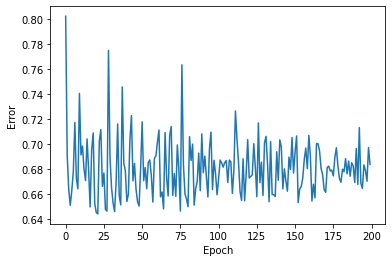

In [60]:
def score_model(rbm):
    test_recon_error = 0  # RMSE reconstruction error initialized to 0 at the beginning of training
    s = 0  # a counter (float type) 
    # for loop - go through every single user
    for id_user in tqdm(range(shape[0])):
        v = train_matrix[id_user:id_user + 1]  # training set inputs are used to activate neurons of my RBM
        vt = test_matrix[id_user:id_user + 1]  # target
        # v = convert_sparse_matrix_to_sparse_tensor(training_sample)
        # vt = convert_sparse_matrix_to_sparse_tensor(training_sample2)
        v = v.todense()
        vt = vt.todense()

        # v = v.to_dense()
        # vt = vt.to_dense()
        v = v - 1
        vt = vt - 1
        v = torch.Tensor(v)
        vt = torch.Tensor(vt)
        if torch.cuda.is_available():
            v = v.cuda()
            vt = vt.cuda()
        if len(vt[vt > -1]) > 0:
            _, h = rbm.sample_h(v)
            _, v = rbm.sample_v(h)

            # Update test RMSE reconstruction error
            test_recon_error += torch.sqrt(torch.mean((vt[vt > -1] - v[vt > -1])**2))
            s += 1

    return test_recon_error / s

print('-------')
n_vis = shape[1]
n_hidden = 12
batch_size = 1024 
train_errors = []
test_errors = []
rbm = RBM(n_vis, n_hidden)

# https://stackoverflow.com/questions/40896157/scipy-sparse-csr-matrix-to-tensorflow-sparsetensor-mini-batch-gradient-descent
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()

    values = coo.data
    indices = np.vstack((coo.row, coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    if torch.cuda.is_available():
        i = i.cuda()
        v = v.cuda()
    # print(values)
    # print("values", v)
    shape = coo.shape
    tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape)) 
    if torch.cuda.is_available():
        tensor = tensor.cuda()

    return tensor 

print("start training")
for epoch in range(200):
    rbm.train()
    train_recon_error = 0  # RMSE reconstruction error initialized to 0 at the beginning of training
    s = 0
    
    for user_id in tqdm(range(0, shape[0] - batch_size, batch_size)):
        training_sample = train_matrix[user_id : user_id + batch_size]
        training_sample2 = train_matrix[user_id : user_id + batch_size]
        # print(training_sample)
        v0 = convert_sparse_matrix_to_sparse_tensor(training_sample)
        # print(v0.coalesce().indices())
        vk = convert_sparse_matrix_to_sparse_tensor(training_sample2)

        v0 = v0.to_dense()
        vk = vk.to_dense()
        v0 = v0.sub(1)
        vk = vk.sub(1)
        
        ph0, _ = rbm.sample_h(v0)   

        # Third for loop - perform contrastive divergence
        for k in range(10):
            _, hk = rbm.sample_h(vk)
            _, vk = rbm.sample_v(hk)

            # We don't want to learn when there is no rating by the user, and there is no update when rating = -1
            # Remove indices from vk vector that are not in the v0 vector => get sparse tensor again
            vk[v0 < 0] = v0[v0 < 0]
            vksparse = vk.to_sparse()
            # print("v0", v0)
            # print("v0", v0.add(1).to_sparse())
            # print("vk", vk.add(1).to_sparse())
            
            # print(k)

        phk, _ = rbm.sample_h(vk)


        rbm.train_model(v0, vk, ph0, phk)
        
        train_recon_error += torch.sqrt(torch.mean((v0[v0 > 0] - vk[v0 > 0])**2))
        s += 1
        
        # print((torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t().shape)
        # print(torch.sum((-vk + v0), 0).shape)
        # print(torch.sum((ph0 - phk), 0).shape)
        
    train_errors.append(train_recon_error / s)

    # print('calculating test scores')
    # rbm.eval()
    # test_errors.append(score_model(rbm))

    print('finished epoch', epoch)    
    
import matplotlib.pyplot as plt
# Plot the RMSE reconstruction error with respect to increasing number of epochs
plt.plot(torch.Tensor(train_errors, device='cpu'), label="train")
plt.plot(torch.Tensor(test_errors, device='cpu'), label="test")
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.savefig('big.jpg')

# Evaluate the RBM on test set
# test_recon_error = score_model(rbm)
# print("Final error", test_recon_error)

In [ ]:
display(train_errors)
display(test_errors)

In [ ]:
s = steam_reviews_df_small["user_id"].value_counts(dropna=False)
display(s.loc[s < 2])
display(s.loc[s >= 2])
display(s)

In [ ]:
test_errors